## Running Over Time

Background: I took up running about 6 years ago after I could barely finish a charity 5k. I thought, "this really shouldn't be so hard" and decided to start training for another 5k. Over the past couple years I have made a ton of progress - both getting faster and being able to run a lot farther. However, I am interested to look into specific measures of progress and explore what trends I can find that may help me continue to improve my running. My dataset is all of my running activities from December 2017 to now as recorded with a Garmin smartwatch. 

In [279]:
#Import some needed packages
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

In [280]:
#Import my dataset and look at a sampling of records
running_df = pd.read_csv('extra_credit_data.csv')
running_df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Avg Pace,Best Pace,Total Ascent,Total Descent,Avg Stride Length,Elapsed Time
0,Running,12/6/21 16:00,Ferndale Running,5.02,439,0:54:23,154,176,162,10:50,8:03,28,28,0.91,0:56:22
1,Running,12/5/21 9:59,Rochester Hills Running,12.37,"1,061",2:10:45,163,187,163,10:34,8:38,253,249,0.93,2:19:00
2,Running,12/4/21 11:24,Ferndale Running,3.06,266,0:33:56,149,176,160,11:05,8:51,6,7,0.91,0:34:05
3,Running,12/3/21 7:25,Ferndale - Workout 7/30,7.75,650,1:25:57,155,175,159,11:05,7:10,26,30,0.91,1:40:28
4,Running,12/1/21 8:12,Ferndale Running,6.00,533,1:07:06,154,188,160,11:11,8:03,26,26,0.90,1:14:58


Above are my most recent running activities, and this is fairly representative of my current running pattern. I typically run 6 days a week. The first record is a shorter recovery run, second record long run, third record shorter run to prepare for the long run, fourth record a speed workout, and last record here is a recovery run. 

Before diving into analyzing this data, there is some necessary cleaning that needs to happen:
* Filter out activities less than 10 minutes as these either flukes or too short to really count
* Fill in zeros for null values (for example a treadmill run does not have total ascent since that cannot be measured by a watch)
* Remove activities that are actually walks/hikes. For this purpose I'll define that as anything where my stride length was less than 0.7 as how far I stride is a good indicator of whether I was picking up my feet or not.


In [281]:
#Create a string version of the time column to use for parsing
running_df['str_time'] = running_df['Time'].astype('str')

#Filter out activities less than 10 minutes (these have a period in them as they count fractions of seconds ie 9:01.12)
running_df = running_df[~running_df['str_time'].str.contains('\.')]

#Filter out small stride lengths to catch walking activities
running_df = running_df[running_df['Avg Stride Length'] > 0.7]


#Replace nulls with zeros
running_df.fillna(0, inplace = True)

In [282]:
total_records = len(running_df)
print("That leaves " + str(total_records) + " total records across 4 years of running.")

That leaves 862 total records across 4 years of running.


Currently my measure of speed is pace, which is formatted as minutes:seconds. For visualization purposes this is not ideal, because a higher value actually indicates a slower pace. I am going to create a new column for speed, which will be recorded as miles per hour. 

In [283]:
#Begin by converting elapsed time into seconds
running_df['total_seconds'] = pd.to_timedelta(running_df['Time']).dt.total_seconds()

#Calculate speed in mph
running_df['avg_speed'] = running_df['Distance'] * 3600 / running_df['total_seconds']

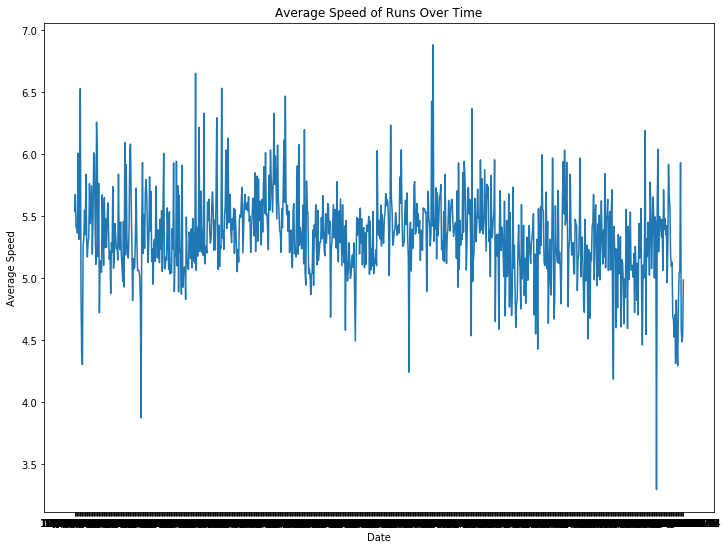

In [284]:
#A simple look at speed over time
fig, ax = plt.subplots()
plt.plot(running_df['Date'], running_df['avg_speed'])
plt.xlabel('Date')
plt.ylabel('Average Speed')
plt.title('Average Speed of Runs Over Time')
plt.show()

This is not a very helpful visualization. The quantity of records in the dataset makes it difficult to know what date is where, and outliers where I either didn't pause my watch, or turned a run into a walk, make it difficult to see patterns. I am going to group activities by month to lessen the effect of outliers and attempt to measure progress over these 4 years. 

When creating this new dataframe, I need to pay attention to which values should be summed and averaged, and which should return the maximum/minimum value. For instance, distance, time, calories, and total ascent should be summed. Avg HR (average heartrate) and avg stride length should be averaged in respect to the length of the run. For Max HR and Best Pace I want to return the maximum and minimum respectively. 

Handling the averages columns is a little tricky, so I will treat them similarly to how I treated speed. I will multiply Avg HR and Avg Stride Length by the distance, sum when I group by month, and then divide each by the total month's distance. This will lend more weight to longer runs.

In [285]:
#Create columns for average calculations
running_df['total_hr'] = running_df['Distance'] * running_df['Avg HR']
running_df['total_stride'] = running_df['Distance'] * running_df['Avg Stride Length']

#Convert Time to timedelta so it can be added when aggregating
running_df['Time'] = pd.to_timedelta(running_df['Time'])

#Convert columns to int type (removing commas in values over 1000)
running_df['Calories'] = running_df['Calories'].str.replace(',','').astype('float')
running_df['Total Ascent'] = running_df['Total Ascent'].str.replace('--','0').str.replace(',', '0').astype('float')

#Create a month column for grouping
running_df['month'] = pd.to_datetime(running_df['Date']).dt.to_period('M')

#Create a new dataframe grouped by month, sum ce
running_month = running_df.groupby('month', as_index= 'False').agg(Distance=('Distance', 'sum'),
                                                                   Calories=('Calories', 'sum'),
                                                                   Time=('Time', 'sum'),
                                                                   Total_HR=('total_hr', 'sum'),
                                                                   Max_HR=('Max HR', 'max'),
                                                                   Best_Pace=('Best Pace', 'min'),
                                                                   Total_Ascent=('Total Ascent', 'sum'),
                                                                   Total_Stride=('total_stride', 'sum'),
                                                                   Total_Seconds=('total_seconds', 'sum'))

In [286]:
#Look at my most recent months of activity
running_month.tail()

,Distance,Calories,Time,Total_HR,Max_HR,Best_Pace,Total_Ascent,Total_Stride,Total_Seconds
month,,,,,,,,,
2021-08,131.11,11449.0,1 days 00:59:02,20076.28,192,1:48,11888.0,116.1242,89942.0
2021-09,163.31,13931.0,1 days 06:18:02,25628.08,197,10:09,1224.0,145.9183,109082.0
2021-10,120.39,10489.0,0 days 22:11:02,19126.69,196,10:07,795.0,108.0574,79862.0
2021-11,116.89,10217.0,0 days 21:31:23,18218.77,191,6:53,1997.0,106.3017,77483.0
2021-12,34.20,2949.0,0 days 06:12:07,5370.58,188,7:10,339.0,31.3094,22327.0


Now to do a little more manipulation to get average speed, average heartrate, and average stride over that time.

In [287]:
running_month['Average_Speed'] = running_month['Distance'] * 3600 / running_month['Total_Seconds']
running_month['Average_HR'] = running_month['Total_HR'] / running_month['Distance']
running_month['Average_Stride'] = running_month['Total_Stride'] / running_month['Distance']

#I'll also calculate ascent over the month in foot/mile
running_month['Ascent'] = running_month['Total_Ascent'] / running_month['Distance']

#Reset index to use month for plotting
running_month = running_month.reset_index()
running_month.tail()

,month,Distance,Calories,Time,Total_HR,Max_HR,Best_Pace,Total_Ascent,Total_Stride,Total_Seconds,Average_Speed,Average_HR,Average_Stride,Ascent
44,2021-08,131.11,11449.0,1 days 00:59:02,20076.28,192,1:48,11888.0,116.1242,89942.0,5.247782,153.125467,0.885701,90.671955
45,2021-09,163.31,13931.0,1 days 06:18:02,25628.08,197,10:09,1224.0,145.9183,109082.0,5.389670,156.929031,0.893505,7.494948
46,2021-10,120.39,10489.0,0 days 22:11:02,19126.69,196,10:07,795.0,108.0574,79862.0,5.426911,158.872747,0.897561,6.603538
47,2021-11,116.89,10217.0,0 days 21:31:23,18218.77,191,6:53,1997.0,106.3017,77483.0,5.430920,155.862520,0.909417,17.084438
48,2021-12,34.20,2949.0,0 days 06:12:07,5370.58,188,7:10,339.0,31.3094,22327.0,5.514400,157.034503,0.915480,9.912281


Now I'll do the same speed plot as before, but grouped by month

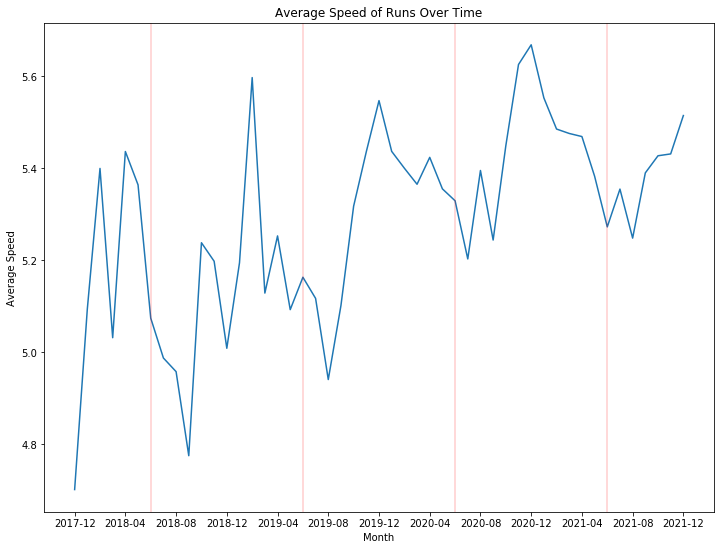

In [288]:
fig, ax = plt.subplots()
plt.plot(running_month['month'].astype('str'), running_month['Average_Speed'])
plt.xlabel('Month')
plt.ylabel('Average Speed')
plt.title('Average Speed of Runs Over Time')
plt.axvline(x= '2018-06', color = 'r', alpha = 0.2)
plt.axvline(x= '2019-06', color = 'r', alpha = 0.2)
plt.axvline(x= '2020-06', color = 'r', alpha = 0.2)
plt.axvline(x= '2021-06', color = 'r', alpha = 0.2)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

Wow! I am relieved to see there is clear evidence that I have actually gotten faster over time. Even with the periodic dips and climbs, we can see there is a clear trend towards rising speeds. I have added red lines at the halfway point of every year, the month of June. With that, it becomes evident that the dips in speed often come at a similar time of year, the summer. Living where I do in the northern hemisphere, July through September is quite hot and humid, both of which have a major effect on running speed.

I am interested as well in the question of what effect running higher volume has on speed. For instance, elite athletes typically run far longer distances than a hobby jogger, and training for longer distances like a marathon often helps people get faster at shorter distances as well. Let's look into this.

## Average Speed and Distance

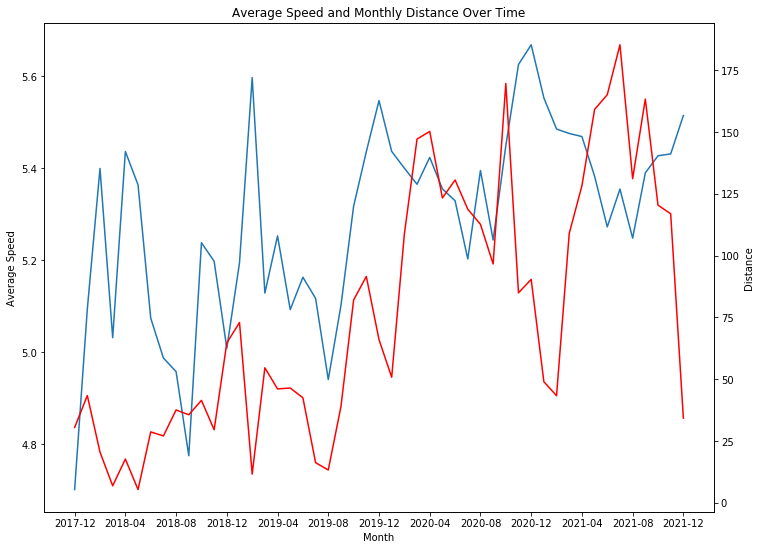

In [289]:
fig, ax = plt.subplots()
plt.plot(running_month['month'].astype('str'), running_month['Average_Speed'])
plt.xlabel('Month')
plt.ylabel('Average Speed')
plt.title('Average Speed and Monthly Distance Over Time')

ax2 = ax.twinx()
ax2.set_ylabel('Distance')
ax2.plot(running_month['month'].astype('str'), running_month['Distance'], color = 'r')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

Interestingly there does seem to be an inverse relationship between average speed in blue and monthly distance in red. Next I'll plot average speed against distance and see whether that appears to hold.

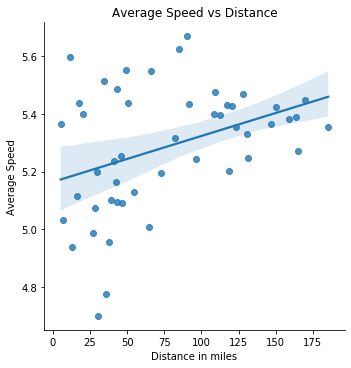

In [290]:
ax3 = sns.lmplot(x = 'Distance', y = 'Average_Speed', data= running_month)
plt.title('Average Speed vs Distance')
plt.xlabel('Distance in miles')
plt.ylabel('Average Speed')
plt.show()

In [291]:
stats.pearsonr(running_month['Average_Speed'], running_month['Distance'])

(0.38010227470495217, 0.007060785095485684)

The Pearson correlation coefficient above of 0.38 suggests there is a slight positive correlation between the two. Taking the null hypothesis to be no correlation between the two, the p-value of 0.007 suggests that we can reject this null hypothesis and there is a correlation, even if it is minor. 

I do not think this suggests the answer to getting faster is to start running a dramatically further distance. For one thing, it's winter in Michigan, and I can really only handle temps of 15 degrees fahrenheit for so long. For another, I ran many more lower mileage weeks when I was just starting out, so this correlation might be better explained by other factors like building endurance or strength over time.

## Heartrate as a Measure of Improved Performance

While speed is one way to measure running performance, effort is another. For example, two runners may run the same time in a 5k, but if one has to run at maximum effort and the other can maintain speed without losing their breath, the second runner is more fit. The best way I have to measure my effort is with heartrate data. A higher heartrate indicates a more strenuous effort. Even if my running speed is not dramatically different from one year to the next, does my average heartrate indicate I have become a better runner?

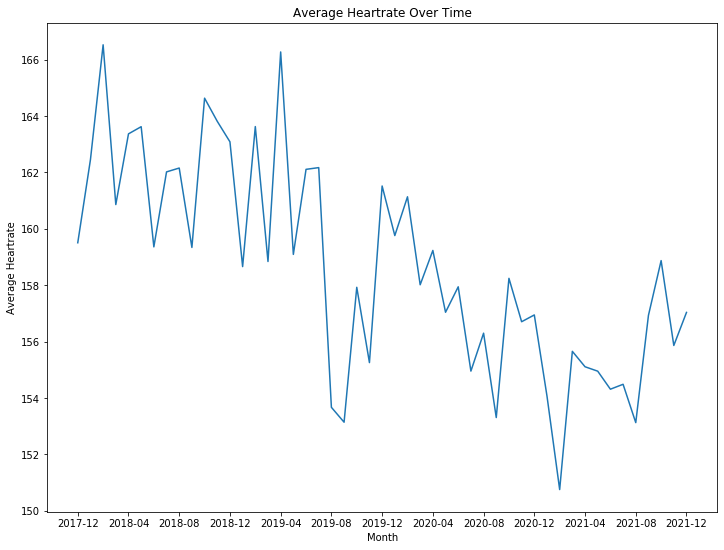

In [292]:
fig4, ax4 = plt.subplots()
plt.plot(running_month['month'].astype('str'), running_month['Average_HR'])
plt.xlabel('Month')
plt.ylabel('Average Heartrate')
plt.title('Average Heartrate Over Time')

ax4.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()


This indicates quite clearly that as time has passed, my average heartrate across all runs has significantly decreased. I am fairly satisfied from the graph alone that this measures indicates that I have made progress in gaining running fitness.

## Measures of Form


I have mainly focused so far on examining my progress over time, rather than trying to gain insight into what actions I could take to improve my running times. I want to next examine certain indicators of form to determine where I should focus my attention to get faster.

There is a lot of advice out there for how to run faster and longer - focus on breathing, lose weight, run more, run less, run slower, run speed workouts. When it really comes down to it, there's two essential things that determine how fast someone runs. 

* How far each step takes you 
* How quickly you take each step

This makes intuitive sense. If you can take bigger steps faster, you can cover more ground. For measuring how far each step takes me, I have stride length, and for how quickly my feet hit the ground I have cadence. Stride length is the number of meters between each footfall and cadence is the number of times per minute a foot hits the ground. A disclaimer that this is measured by a device on my wrist so neither are entirely accurate, but I think my smart watch does a pretty good job at it.

I am going to return to individual activity data to have a larger dataset to draw upon. Here is my original dataset again.

In [293]:
running_df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Avg Pace,...,Total Ascent,Total Descent,Avg Stride Length,Elapsed Time,str_time,total_seconds,avg_speed,total_hr,total_stride,month
0,Running,12/6/21 16:00,Ferndale Running,5.02,439.0,00:54:23,154,176,162,10:50,...,28.0,28,0.91,0:56:22,0:54:23,3263.0,5.538462,773.08,4.5682,2021-12
1,Running,12/5/21 9:59,Rochester Hills Running,12.37,1061.0,02:10:45,163,187,163,10:34,...,253.0,249,0.93,2:19:00,2:10:45,7845.0,5.676482,2016.31,11.5041,2021-12
2,Running,12/4/21 11:24,Ferndale Running,3.06,266.0,00:33:56,149,176,160,11:05,...,6.0,7,0.91,0:34:05,0:33:56,2036.0,5.410609,455.94,2.7846,2021-12
3,Running,12/3/21 7:25,Ferndale - Workout 7/30,7.75,650.0,01:25:57,155,175,159,11:05,...,26.0,30,0.91,1:40:28,1:25:57,5157.0,5.410122,1201.25,7.0525,2021-12
4,Running,12/1/21 8:12,Ferndale Running,6.00,533.0,01:07:06,154,188,160,11:11,...,26.0,26,0.90,1:14:58,1:07:06,4026.0,5.365127,924.00,5.4000,2021-12


Before continuing, I am going to remove any treadmill running, as the data will be less accurate than a GPS-based measurement, and running on a short moving belt can have a major affect on running form that I do not want to have to account for. Also, I have not run on a treadmill since February 2020 and will continue to run only outside for the foreseeable future, so I am looking to gain insights about outdoor running specifically. 

In [294]:
#Treadmill activities are coded as 'Treadmill Running' in the Activity Type column. I will remove those
running_df = running_df[running_df['Activity Type'] != 'Treadmill Running']

It is likely that higher cadence and greater stride length are positively correlated, because it is easier to shuffle with short steps and sprint with large steps. The question I am looking to answer here is: which one has a stronger correlation to speed. With this knowledge I can be more mindful of either focusing on picking my feet up faster or increasing flexibility to take longer steps.

To attempt to answer this question, I will make a correlation matrix heatmap

                   avg_speed  Avg Run Cadence  Avg Stride Length
avg_speed           1.000000         0.756847           0.875544
Avg Run Cadence     0.756847         1.000000           0.356923
Avg Stride Length   0.875544         0.356923           1.000000


[Text(0.5, 0, 'avg_speed'),
 Text(1.5, 0, 'Avg Run Cadence'),
 Text(2.5, 0, 'Avg Stride Length')]

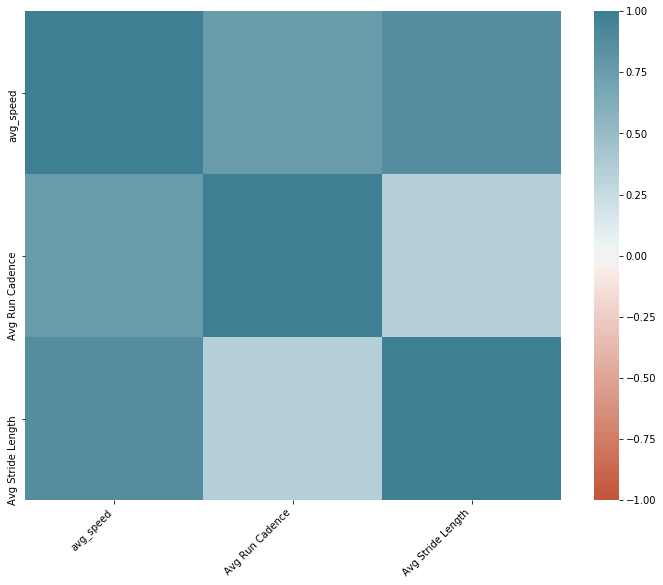

In [295]:
#Convert Average Stride Length to float for correlation calculations
running_df['Avg Run Cadence'] = running_df['Avg Run Cadence'].astype('float')

corr = running_df[['avg_speed', 'Avg Run Cadence','Avg Stride Length']].corr()
print(corr)
ax5 = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap= sns.diverging_palette(20,220, n = 200))
ax5.set_xticklabels(ax5.get_xticklabels(), rotation = 45, horizontalalignment = 'right')


From the heatmap we see a slightly darker shade of blue for the square that correlates stride length and speed than the square indicating correlation between cadence and speed. The correlation coefficients are 0.8186 and 0.7589 for stride length and cadence respectively. 

To be entirely honest, I am a little disappointed to see this. As someone who is only 5'2", I feel that I already take fairly large strides for my leg length just to keep up with others. It is also the icy season where I live, which necessitates being more cautious and taking smaller steps. However, a quick google search revealed another way to increase stride length is to create more force from your lengths by building strength. Guess that means I need to start lifting while stuck inside this winter.

## Looking Ahead

There are any number of questions I can ask with this data. Another big debate in the running community is whether you should take days off from running or keep a run streak. I currently run 6 days a week, but I would be interested to see if I ran faster over periods where I ran fewer days a week. I might approach this by comparing runs of equal distance where I either did run the day before or did not. Especially with winter coming in, it might be nice to know that taking more days off actually improves performance. 

I would also like to explore the effects of hillier running on my fitness. Where I live is extremely flat, and when I recently ran a 5k in a hilly mountain city, I could not handle the hills. I would like to dive into how running with greater ascent might improve my running on flat routes. 

Weather can be a huge factor in how easy or difficult a run is. I have longitude and latitude values that I could use to tie my activities to weather data and look at the effect of heat, humidity, snow, and rain on speed.

I typically run in the morning in the summer and transition to the afternoon in the winter to make the most of cooler summer temps and warmer winter temps, but I wonder whether I perform better at a specific time of day.

## Conclusion

Although this data is accessible to me in an app and online portal, I am typically limited to looking only at the last year, and my options for comparing different features of a run are limited. It has been fun to look a little deeper into questions I have had for a long time now and make exactly the visualizations that I want to see.